# Import packages

In [1]:
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, make_scorer
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve
from lightgbm import LGBMClassifier
from sklearn import datasets

In [2]:
def prepare_column_names(columns):
    return [col.replace(' ', '').replace('(cm)', '_cm') for col in columns]

In [3]:
sklearn_data = datasets.load_iris()
columns = prepare_column_names(sklearn_data.feature_names)
df = pd.DataFrame(data=sklearn_data.data, columns=columns)
df['class'] = sklearn_data.target
df['class'] = df['class'].astype(str)
df.head()

,sepallength_cm,sepalwidth_cm,petallength_cm,petalwidth_cm,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
target = 'class'
X = df.drop(target, axis=1).copy()
Y = df.loc[:, target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

In [5]:
classes = ['setosa', 'versicolor', 'virginica']
numerical_features = X.columns.tolist()

In [6]:
def classification_report(model):
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()                 

In [7]:
def roc_auc(model):
    visualizer = ROCAUC(model, classes=classes)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [8]:
def confusion_matrix(model):
    visualizer = ConfusionMatrix(model, classes=classes)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [9]:
def precision_recall_curve(model):
    visualizer = PrecisionRecallCurve(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [10]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(accuracy_score, greater_is_better=True)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [11]:
def create_new_model():
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state=77))
    return model

# Using LightGBM

In [12]:
lgbm_model = LGBMClassifier(n_estimators=100, random_state=7)

In [13]:
score_model(lgbm_model, X, Y)

Mean of metric: 0.9466666666666667, std: 0.03999999999999999


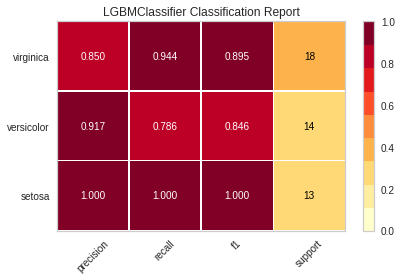

In [14]:
classification_report(lgbm_model)

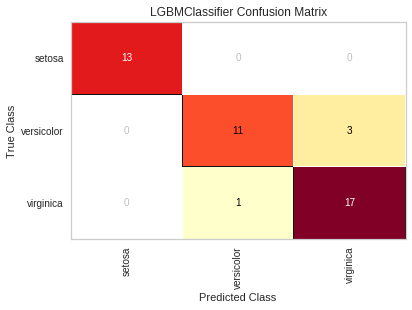

In [15]:
confusion_matrix(lgbm_model)

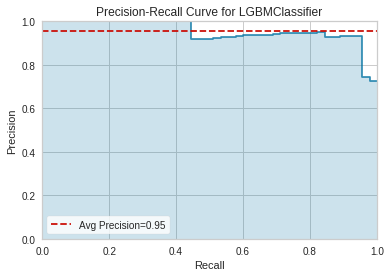

In [16]:
precision_recall_curve(lgbm_model)

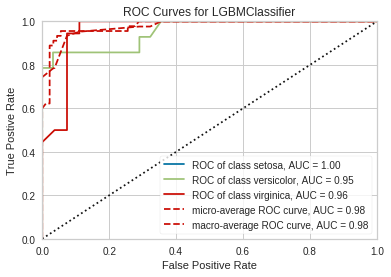

In [17]:
roc_auc(lgbm_model)

# Using Logistic Regression

In [18]:
model = create_new_model()

In [19]:
score_model(model, X, Y)

Mean of metric: 0.9, std: 0.0683130051063973


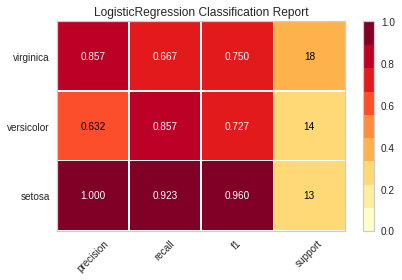

In [20]:
classification_report(model)

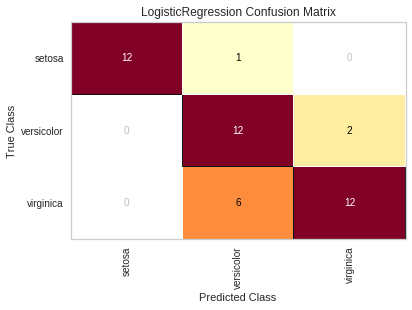

In [21]:
confusion_matrix(model)

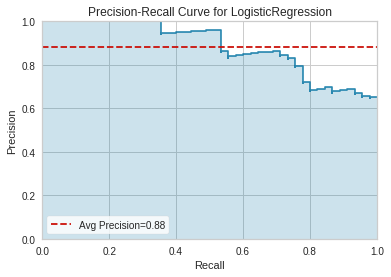

In [22]:
precision_recall_curve(model)

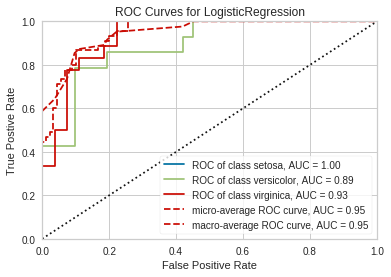

In [23]:
roc_auc(model)

# Using ATgfe

In [24]:
model = create_new_model()

In [25]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=numerical_features,
                             number_of_candidate_features=6,
                             number_of_interacting_features=4,
                             evaluation_metric=accuracy_score, minimize_metric=False, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=False, enable_weights=False)

2019-11-16 20:53:58,502:INFO: New Engineer created with the following parameters: 
2019-11-16 20:53:58,504:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['sepallength_cm', 'sepalwidth_cm', 'petallength_cm', 'petalwidth_cm']
Number of candidate features: 6
Number of interacting features: 4
Evaluation Metric: accuracy_score
Minimize metric is False 


In [26]:
gfe.fit(population_size=1000, early_stopping_patience=3)

2019-11-16 20:53:58,692:INFO: Start of evolution 
2019-11-16 20:54:10,960:INFO:   Evaluated 1000 individuals 
2019-11-16 20:54:10,963:INFO: -- Generation 1 -- 
2019-11-16 20:54:20,366:INFO:   Evaluated 608 individuals 
2019-11-16 20:54:20,370:INFO:   Min -1000000000000.0 
2019-11-16 20:54:20,371:INFO:   Max 1.0 
2019-11-16 20:54:20,372:INFO:   Avg -153099999999.18674 
2019-11-16 20:54:20,373:INFO:   Std 356188699989.5542 
2019-11-16 20:54:22,555:INFO: Generation: 1, validation scores: [1.         1.         1.         0.90909091 0.90909091 0.90909091
 1.         1.         1.         1.        ], mean_score: 0.9727272727272727 
2019-11-16 20:54:22,557:INFO: Generation: 1, best solution features: ['sepallength_cm', 'sepalwidth_cm', 'petallength_cm', 'petalwidth_cm', '-petallength_cm*petalwidth_cm + sepallength_cm', 'petallength_cm + sepalwidth_cm', '-petallength_cm*sepallength_cm/sepalwidth_cm + petallength_cm', 'sepalwidth_cm', 'petallength_cm', 'petallength_cm - petalwidth_cm*sepallen

# Apply GFE

In [27]:
X = gfe.transform(X)

In [28]:
X.head(20)

,sepallength_cm,sepalwidth_cm,petallength_cm,petalwidth_cm,0,petallength_cm + sepallength_cm/petalwidth_cm,petallength_cm - 1,petallength_cm*petalwidth_cm**2/sepalwidth_cm,petalwidth_cm*sepalwidth_cm - petalwidth_cm + sepalwidth_cm,-petallength_cm*petalwidth_cm + petallength_cm + sepallength_cm
0,5.1,3.5,1.4,0.2,0.0,26.900000,0.4,0.016000,4.00,6.22
1,4.9,3.0,1.4,0.2,0.0,25.900000,0.4,0.018667,3.40,6.02
2,4.7,3.2,1.3,0.2,0.0,24.800000,0.3,0.016250,3.64,5.74
3,4.6,3.1,1.5,0.2,0.0,24.500000,0.5,0.019355,3.52,5.80
4,5.0,3.6,1.4,0.2,0.0,26.400000,0.4,0.015556,4.12,6.12
5,5.4,3.9,1.7,0.4,0.0,15.200000,0.7,0.069744,5.06,6.42
6,4.6,3.4,1.4,0.3,0.0,16.733333,0.4,0.037059,4.12,5.58
7,5.0,3.4,1.5,0.2,0.0,26.500000,0.5,0.017647,3.88,6.20
8,4.4,2.9,1.4,0.2,0.0,23.400000,0.4,0.019310,3.28,5.52
9,4.9,3.1,1.5,0.1,0.0,50.500000,0.5,0.004839,3.31,6.25


In [29]:
model = create_new_model()

In [30]:
score_model(model, X, Y)

Mean of metric: 0.9600000000000002, std: 0.06110100926607785


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

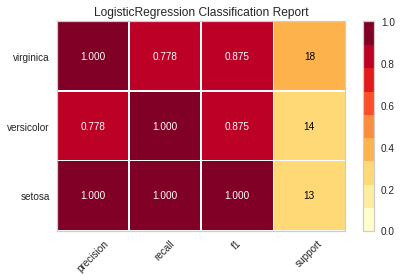

In [32]:
classification_report(model)

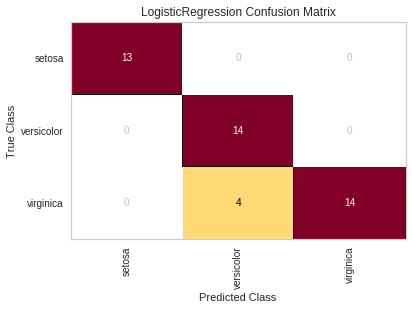

In [33]:
confusion_matrix(model)

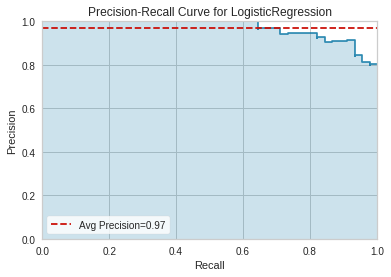

In [34]:
precision_recall_curve(model)

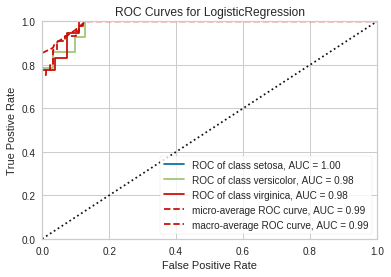

In [35]:
roc_auc(model)

# Run ATgfe with operations and weights

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)
columns = X.columns.tolist()

In [37]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=columns,
                             number_of_candidate_features=4,
                             number_of_interacting_features=4,
                             evaluation_metric=accuracy_score, minimize_metric=True, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=True, enable_weights=True)

2019-11-16 20:55:11,688:INFO: New Engineer created with the following parameters: 
2019-11-16 20:55:11,689:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['sepallength_cm', 'sepalwidth_cm', 'petallength_cm', 'petalwidth_cm', '0', 'petallength_cm + sepallength_cm/petalwidth_cm', 'petallength_cm - 1', 'petallength_cm*petalwidth_cm**2/sepalwidth_cm', 'petalwidth_cm*sepalwidth_cm - petalwidth_cm + sepalwidth_cm', '-petallength_cm*petalwidth_cm + petallength_cm + sepallength_cm']
Number of candidate features: 4
Number of interacting features: 4
Evaluation Metric: accuracy_score
Minimize metric is True 


In [38]:
gfe.fit(population_size=1000, early_stopping_patience=3)

2019-11-16 20:55:11,816:INFO: Start of evolution 
2019-11-16 20:55:14,913:INFO:   Evaluated 1000 individuals 
2019-11-16 20:55:14,915:INFO: -- Generation 1 -- 
2019-11-16 20:55:16,997:INFO:   Evaluated 604 individuals 
2019-11-16 20:55:17,001:INFO:   Min 1000000000.0 
2019-11-16 20:55:17,012:INFO:   Max 100000000000.0 
2019-11-16 20:55:17,013:INFO:   Avg 4465000000.0 
2019-11-16 20:55:17,014:INFO:   Std 18194196189.99438 
2019-11-16 20:55:17,021:INFO: -- Generation 2 -- 
2019-11-16 20:55:19,413:INFO:   Evaluated 625 individuals 
2019-11-16 20:55:19,417:INFO:   Min 1.0 
2019-11-16 20:55:19,418:INFO:   Max 100000000000.0 
2019-11-16 20:55:19,419:INFO:   Avg 4163000000.005 
2019-11-16 20:55:19,420:INFO:   Std 17425051822.01651 
2019-11-16 20:55:21,553:INFO: Generation: 2, validation scores: [1.         1.         1.         0.90909091 1.         1.
 1.         1.         1.         1.        ], mean_score: 0.990909090909091 
2019-11-16 20:55:21,555:INFO: Generation: 2, best solution featu

In [39]:
X = gfe.transform(X)

In [40]:
model = create_new_model()

In [41]:
score_model(model, X, Y)

Mean of metric: 0.9733333333333334, std: 0.04422166387140532


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

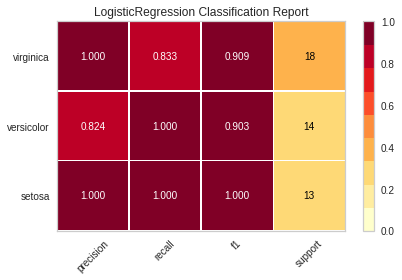

In [43]:
classification_report(model)

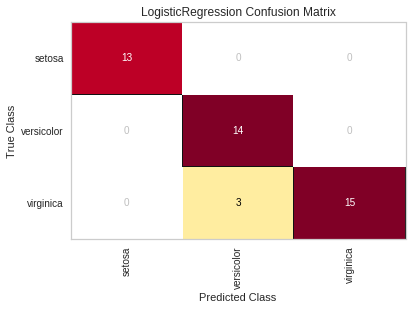

In [44]:
confusion_matrix(model)

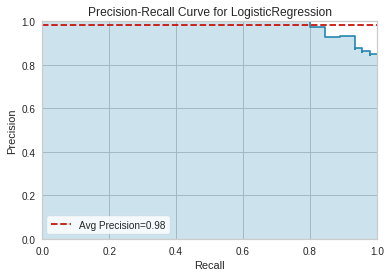

In [45]:
precision_recall_curve(model)

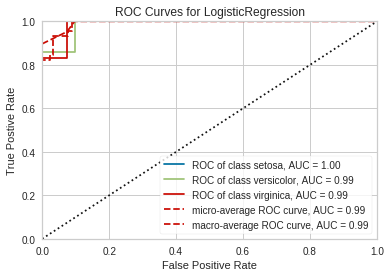

In [46]:
roc_auc(model)